In [2]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('IMDB Dataset.csv')
df.shape

(50000, 2)

In [4]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


(array([0, 1]), [Text(0, 0, 'positive'), Text(1, 0, 'negative')])

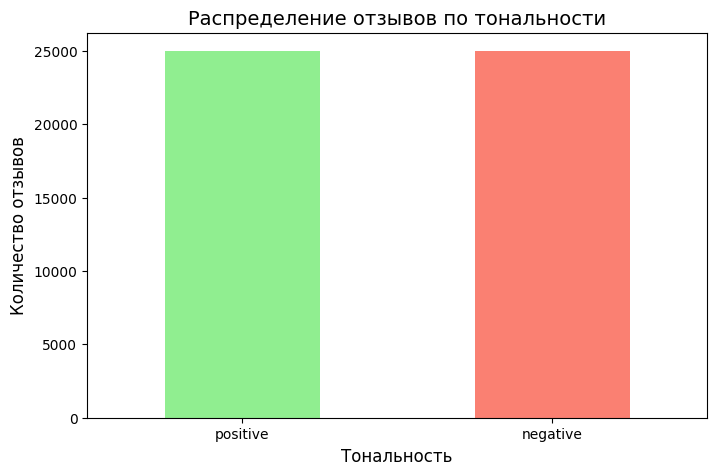

In [5]:
plt.figure(figsize=(8, 5))
ax = df['sentiment'].value_counts().plot(kind='bar', color=['lightgreen', 'salmon'])

# Настройка оформления
plt.title('Распределение отзывов по тональности', fontsize=14)
plt.xlabel('Тональность', fontsize=12)
plt.ylabel('Количество отзывов', fontsize=12)
plt.xticks(rotation=0)


In [ ]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Split 80% train, 20% temp (val+test)
train, temp = train_test_split(df, test_size=0.20, random_state=42, stratify=df['sentiment'])

# Step 2: Split 20% temp into 10% val and 10% test (i.e., 50% of temp each)
val, test = train_test_split(temp, test_size=0.50, random_state=42, stratify=temp['sentiment'])

# Check proportions
print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")                    

Train: 40000, Val: 5000, Test: 5000


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train["review"])
# Convert text to sequences and pad
X_train = pad_sequences(tokenizer.texts_to_sequences(train["review"]), maxlen=200)
X_val = pad_sequences(tokenizer.texts_to_sequences(val["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test["review"]), maxlen=200)

# Target variables
Y_train = train["sentiment"].values
Y_val = val["sentiment"].values
Y_test = test["sentiment"].values

[[   0    0    0 ...    3 3598  157]
 [   0    0    0 ...  103    9  554]
 [   0    0    0 ...    1  213   27]
 ...
 [   0    0    0 ...  138    5    3]
 [   0    0    0 ...   10   98  131]
 [   0    0    0 ...  152   63    9]]


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Build the model with GRU
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

# Use Adam with gradient clipping to avoid exploding gradients
optimizer = Adam(clipnorm=1.0)

# Compile the model
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=8,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping],
)

model.summary()

C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 156s 121ms/step - accuracy: 0.7382 - loss: 0.5149 - val_accuracy: 0.8754 - val_loss: 0.3044
Epoch 2/8
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 178s 142ms/step - accuracy: 0.8920 - loss: 0.2638 - val_accuracy: 0.9032 - val_loss: 0.2344
Epoch 3/8
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 190s 152ms/step - accuracy: 0.9303 - loss: 0.1875 - val_accuracy: 0.9026 - val_loss: 0.2290
Epoch 4/8
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 193s 154ms/step - accuracy: 0.9427 - loss: 0.1565 - val_accuracy: 0.9006 - val_loss: 0.2494


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 200, 128)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (32, 64)               │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,031,941 (7.75 MB)

 Trainable params: 677,313 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,354,628 (5.17 MB)

In [23]:
model.save("my_model.keras")

In [26]:
from tensorflow.keras.models import load_model

model = load_model("my_model.keras")

loss, accuracy = model.evaluate(X_test, Y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9037 - loss: 0.2359
Test Loss: 0.2445
Test Accuracy: 0.8986


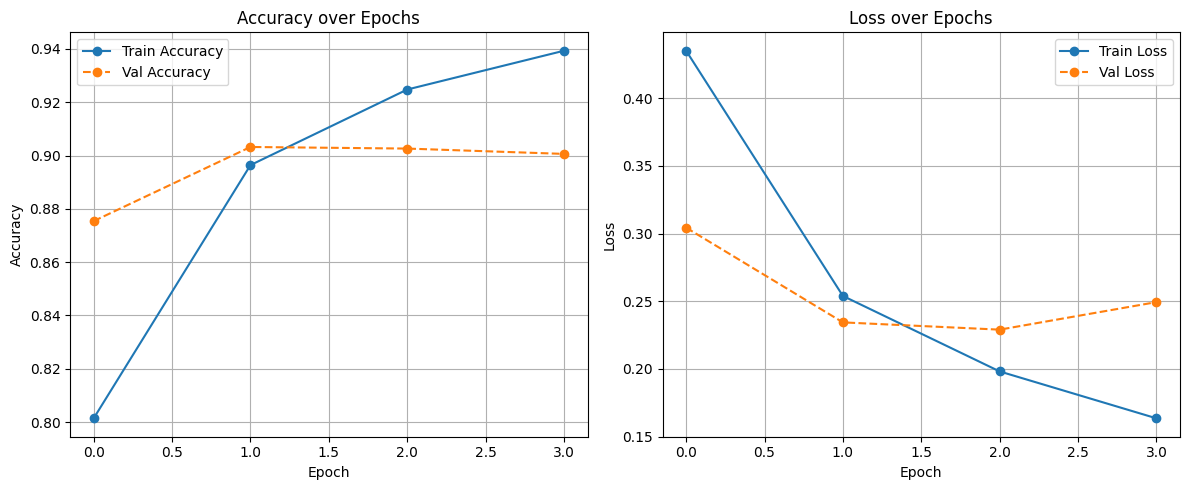

In [35]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='--', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--', marker='o')  # Dotted line
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [40]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)

Y_pred = (Y_pred > 0.5).astype(int)

cm = confusion_matrix(Y_test, Y_pred)

print(cm)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
[[2248  252]
 [ 255 2245]]
